In [10]:
import os
from skimage import io
import csv
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np
%matplotlib inline

In [12]:
RESOLUTION = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=RESOLUTION, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=transforms.InterpolationMode.BICUBIC),
    v2.RandomRotation(20),  # Randomly rotate images by a certain degree
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),  # Transform to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet standards
])

# Define a transform for the validation data without data augmentation
val_transform = transforms.Compose([
    v2.Resize((RESOLUTION, RESOLUTION), interpolation=transforms.InterpolationMode.BICUBIC),  # Resize images to a common size
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),  # Transform to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet standards
])

In [15]:
csv_path = 'train_labeled.csv'
labeled_path = 'train/labeled'

class CustomDataset(Dataset):
    def __init__(self, csv_file, train_path, transform=None):
        self.train_labeled = train_path
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.train_labeled + '/' + self.df.image[idx]
        image = datasets.folder.default_loader(img_path)
        label = self.df.id[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

labeled_train_dataset = CustomDataset(csv_path, labeled_path, train_transform)
labeled_val_dataset = CustomDataset(csv_path, labeled_path, val_transform)

num_train = len(labeled_train_dataset)
indices = list(range(num_train))
split_idx = int(np.floor(.1 * num_train))
valid_idx, train_idx = indices[:split_idx], indices[split_idx:]

train_indices, val_indices = train_test_split(indices, test_size=.2)
labeled_train_dataset = torch.utils.data.Subset(labeled_train_dataset, train_indices)
labeled_val_dataset = torch.utils.data.Subset(labeled_val_dataset, val_indices)

In [16]:
print(len(labeled_train_dataset), len(labeled_val_dataset))

7883 1971


In [17]:
BATCH_SIZE = 1
train_label_loader = DataLoader(dataset=labeled_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_label_loader = DataLoader(dataset=labeled_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(6)


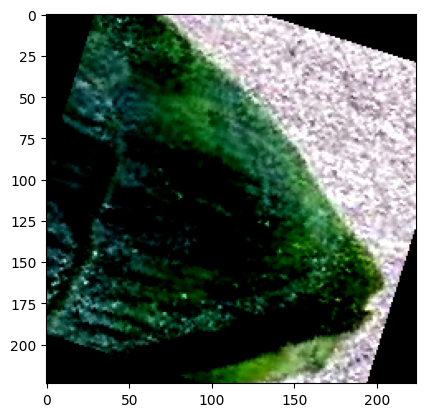

In [20]:
def imshow(img, un):
    if(un):
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_iter = iter(train_label_loader)
images, labels = next(train_iter)
print(labels[0])
imshow(make_grid(images[0]), True)

In [22]:
test_dir = 'test'

# For the test set, since there are no labels, we need to create a custom DataSet.
class UnlabeledDataset(datasets.VisionDataset):
    def __init__(self, root, transform=None):
        super(UnlabeledDataset, self).__init__(root, transform=transform)
        self.images = [os.path.join(root, img) for img in os.listdir(root)]

    def __getitem__(self, index):
        image_path = self.images[index]
        image = datasets.folder.default_loader(image_path)  # default loader is PIL.Image.open
        if self.transform:
            image = self.transform(image)
        return image, str(image_path)

    def __len__(self):
        return len(self.images)

# Create a dataset for your test data
test_dataset = UnlabeledDataset(root=test_dir, transform=val_transform)

# Create a DataLoader for your test set
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
vit_l16 = torch.hub.load("facebookresearch/swag", model="vit_l16")

Downloading: "https://github.com/facebookresearch/swag/zipball/main" to /home/jupyter/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/SWAG/vit_l16.torch" to /home/jupyter/.cache/torch/hub/checkpoints/vit_l16.torch
100%|██████████| 1.13G/1.13G [00:03<00:00, 373MB/s]


In [24]:
class ModifiedViT(nn.Module):
    def __init__(self, pretrained_model):
        super(ModifiedViT, self).__init__()
        self.pretrained = pretrained_model
        self.pretrained.head = nn.Identity()  # remove the existing linear layer
        for param in self.pretrained.parameters():
            param.requires_grad = False

        self.new_head = nn.Sequential(
            nn.Linear(1024, 135),  # Adjust the input size to match the output size of the ViT model
        )

    def forward(self, x):
        x = self.pretrained(x)
        x = self.new_head(x)
        return x

# Create the modified model
model = ModifiedViT(vit_l16)

In [25]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.new_head.parameters(), lr=0.001, weight_decay=0.005)

In [ ]:
# Send the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 3  # Replace with the number of epochs you want

# Lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_label_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update progress bar
            tepoch.set_postfix(loss=(running_loss / (tepoch.n + 1)), accuracy=(correct_predictions / total_predictions))

    # Calculate and print loss and accuracy for the training phase
    epoch_loss = running_loss / len(train_label_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    # Disable gradient calculation for validation to save memory and computations
    with torch.no_grad():
        with tqdm(val_label_loader, unit="batch") as vepoch:
            for images, labels in vepoch:
                vepoch.set_description(f"Validation Epoch {epoch+1}/{num_epochs}")

                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

                # Update progress bar
                vepoch.set_postfix(val_loss=(val_running_loss / (vepoch.n + 1)), val_accuracy=(val_correct_predictions / val_total_predictions))

    # Calculate and print loss and accuracy for the validation phase
    val_epoch_loss = val_running_loss / len(val_label_loader.dataset)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Print summary for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')